## Note: Please ensure you run this workbook from the same folder as where the underlying data is stored in your computer.

# Preparing the Environment for Exploratory Data Analysis

In [1]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import math
import squarify


from pywaffle import Waffle
from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

# Setting up a date parser using a private funciton, lambda
# This will give us the dates in a format we require for aggregation & indexation
d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

In [2]:
# Load the CSV file(s).
counts = pd.read_csv('NY_Bicycle_Counts.csv', parse_dates=['date'], date_parser=d_parser)
parking = pd.read_csv('NY_Bicycle_Parking.csv')
routes = pd.read_excel('NY_Bicycle_Routes.xlsx')

In [3]:
# View the DataFrame, metadata, shape
counts.info()
parking.info()
routes.info()

# Counts is a large but simple Df containing the number of bicycles passing through a counter
# Parking contains geographic details of bicycle racks in the city of NY
# Routes contains geographic details of list of bike lanes and routes in the city of NY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      int64         
 1   date    datetime64[ns]
 2   counts  int64         
 3   status  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 127.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30178 entries, 0 to 30177
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   BoroCode    30178 non-null  int64 
 1   BoroName    30178 non-null  object
 2   CounDist    30178 non-null  int64 
 3   AssemDist   30178 non-null  int64 
 4   StSenDist   30178 non-null  int64 
 5   CongDist    30178 non-null  int64 
 6   STREETON    17710 non-null  object
 7   XSTREET1    21881 non-null  object
 8   XSTREET2    21771 non-null  object
 9   SIDE        18395 non-null  object
 10  ASSETSUBTY  30178 non-null  object
dtypes: int64(5), object(6)
memo

## EDA on Counts DataFrame

### Data  Wrangling

In [4]:
# Check for missing values in counts
counts.isnull().sum()

# No missing values

id        0
date      0
counts    0
status    0
dtype: int64

In [5]:
# Make sure that the data is sorted in cbronological order without altering anything else for the moment
counts.sort_values(by='date')

# Can see data set runs from 31 Aug 2012 to 04 Jul 2022
# Can extract hour of the day to look for patterns. Expect peak vs off peak patterns
# We can also group the data by day of the week to look for patterns within that
# We can also see that its possible to group the data into month to look for seasonal patterns
# We can also group/subset the data by id which is another spatial/location identifier

,id,date,counts,status
2059019,100047029,2012-08-31 00:00:00,41,4
3205445,100062893,2012-08-31 00:00:00,41,4
4164087,100005020,2012-08-31 00:00:00,41,4
2370586,100051865,2012-08-31 00:00:00,41,4
4165734,100005020,2012-08-31 00:15:00,52,4
...,...,...,...,...
16707,100062893,2022-07-04 23:45:00,34,0
16803,300020241,2022-07-04 23:45:00,16,0
16995,300024007,2022-07-04 23:45:00,2,0
16323,100047029,2022-07-04 23:45:00,34,0


In [6]:
# Extract year information from timestamped date column
counts['year'] = counts['date'].dt.year

In [7]:
# Define night and day to calculate user defined peak and off peak hours
# Extract hour information first from timestamped date column
counts['hour'] = counts['date'].dt.hour

In [8]:
# Create user defined function for peak and off peak hours
def f(x):
    if (x > 6) and (x <= 7):
        return 'Early Morning'
    elif (x > 7) and (x <= 10 ):
        return 'AM peak'
    elif (x > 10) and (x <= 16):
        return'Inter Peak'
    elif (x > 16) and (x <= 19) :
        return 'PM Peak'
    elif (x > 19) and (x <= 23):
        return'Evening'
    elif (x <= 6):
        return'Night'

# Apply user defined function to create new column with peak and off peak hours
counts['time_of_day'] = counts['hour'].apply(f)

In [9]:
# Define day of the week and add as column
counts = counts.assign(day_of_week = lambda x: x.date.dt.day_name())

In [10]:
# Define month to calculate user defined seasons
# Extract month information first from timestamped date column
counts['month'] = counts['date'].dt.month

In [11]:
# Create user defined function for seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
counts['season'] = counts['month'].apply(f)

In [12]:
# Reshaping the order of the columns so they flow more logically within the DataFrame
neworder = ['id', 'date', 'day_of_week', 'month', 'season', 'year', 'hour', 'time_of_day', 'counts', 'status']
counts = counts.reindex(columns=neworder)

In [13]:
# Look at 10 rows randomly to ensure all user defined columns correctly populated
counts.sample(10)

,id,date,day_of_week,month,season,year,hour,time_of_day,counts,status
2874713,100009425,2020-06-15 00:15:00,Monday,6,Summer,2020,0,Night,11,0
1635705,100010020,2016-11-24 18:45:00,Thursday,11,Autumn,2016,18,PM Peak,5,0
598157,100009428,2020-12-30 21:15:00,Wednesday,12,Winter,2020,21,Evening,33,0
1036189,100010017,2020-11-06 04:15:00,Friday,11,Autumn,2020,4,Night,0,0
3452252,100062893,2020-07-15 19:15:00,Wednesday,7,Summer,2020,19,PM Peak,136,0
1513330,100010019,2022-03-11 23:00:00,Friday,3,Spring,2022,23,Evening,9,0
2292410,100047029,2020-03-18 19:45:00,Wednesday,3,Spring,2020,19,PM Peak,22,0
1652670,100010020,2017-05-18 14:30:00,Thursday,5,Spring,2017,14,Inter Peak,66,0
580018,100009428,2020-07-13 19:45:00,Monday,7,Summer,2020,19,PM Peak,85,0
637274,100009428,2022-01-01 16:30:00,Saturday,1,Winter,2022,16,Inter Peak,30,0


### Creating Visualisations: How has cycling uptake evolved over time?

In [14]:
# Aggregate data by year
df=counts.groupby(['year'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('year', inplace=True)

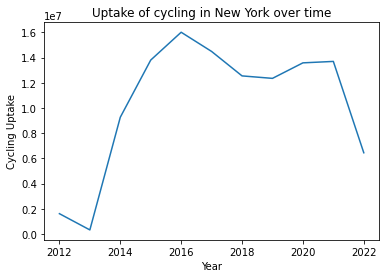

In [15]:
#Creating the line chart
plt.plot(df['year'], df['counts']) 
#Adding the aesthetics
plt.title('Uptake of cycling in New York over time')
plt.xlabel('Year')
plt.ylabel('Cycling Uptake') 
#Show the plot
plt.show()

# Interesting that peak was 2016
# Sharp decline in mid 2020 due to COVID-19
# 2022 data still not showing uptake pickup although data is not for full year in 2022

### Creating Data Visualisations : Does time of the day Matter?

In [16]:
# Aggregate data by time of day
df=counts.groupby(['time_of_day'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('counts', inplace=True)

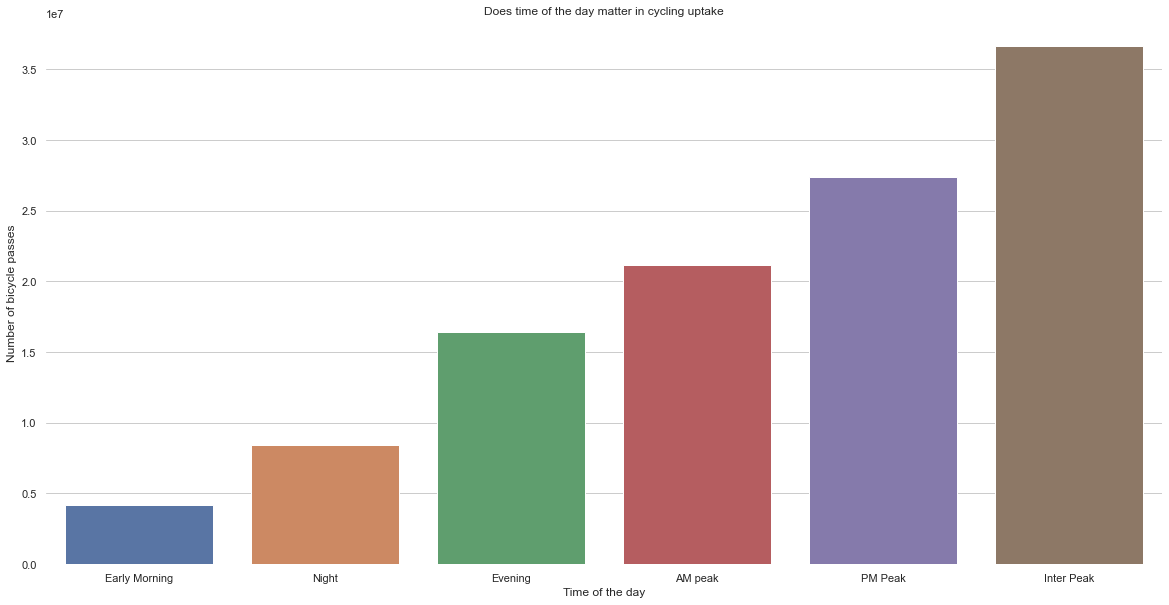

In [17]:
# Visualise to see which time of day has the highest count of cycling
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialize the matplotlib figure
f, g = plt.subplots(figsize=(20, 10))

g=sns.barplot(x = df["time_of_day"], y = df["counts"])

# Add a legend and informative axis label
g.set(ylabel="Number of bicycle passes",
       xlabel="Time of the day")
g.set_title('Does time of the day matter in cycling uptake')
sns.despine(left=True, bottom=True)
plt.show()

# Surprisingly peak hours dont show highest use!
# So are cyclists more leisure users than commuters?
# Need to explore why more are not cycling during peak hours.

### Creating Data Visualisations: Does Day of the Week matter?

In [18]:
# Aggregate data by time of day
df=counts.groupby(['day_of_week'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('counts', inplace=True)

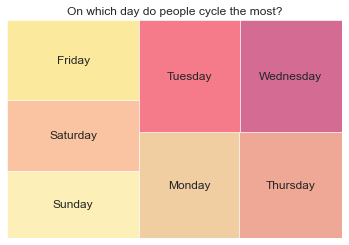

In [19]:
# Plotting a treemap
# Colour Palette
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

# Set Plot Style
sns.set_style(style="whitegrid") 

# Setting the variable
sizes= df["counts"].values
label=df["day_of_week"]

# Setting the styles
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='On which day do people cycle the most?')
plt.axis('off')
plt.show()

# Except weekends, not big differences
# Mid week days Tuesday & Wednesdays shows greatest number
# Will be interesting to see how these compare with the other cities

### Creating Data Visualisations: Do seasons matter?

In [20]:
# Aggregate data by time of day
df=counts.groupby(['season'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('counts', inplace=True)
df

,season,counts
3,Winter,17766649
1,Spring,27985178
0,Autumn,31873111
2,Summer,36459568


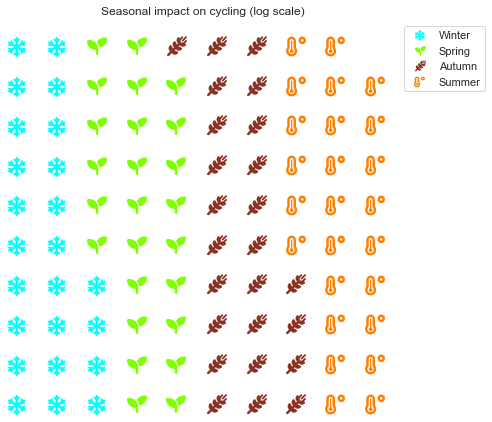

In [39]:
# Visualise in a Waffle Chart
fig = plt.figure(
    FigureClass=Waffle,
    rows=10, columns = 10, figsize = (7,15), title = {'label': 'Seasonal impact on cycling (log scale)'},
    values=[math.log(17766649), math.log(27985178), math.log(31873111), math.log(36459568)],
    colors=["#00FFFF", "#7FFF00", "#8A3324", "#FF7F00"],
    icons=['snowflake', 'seedling', 'wheat-awn', 'temperature-high'],
    font_size=20,
    icon_style='solid',
    icon_legend=True,
    legend={
        'labels': ['Winter', 'Spring', 'Autumn', 'Summer'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1)
    }
)
# Kevin to note on prettifying

### Creating Data Visualisations: Does location matter?

In [29]:
# Count the number of unique values for id
print(counts.nunique())

# Shows 25 spatial/locational data

id                 25
date           344996
day_of_week         7
month              12
season              4
year               11
hour               24
time_of_day         6
counts            939
status              2
dtype: int64


In [30]:
# Group by Spatial ID
df=counts.groupby(['id'], as_index=False)['counts'].sum()

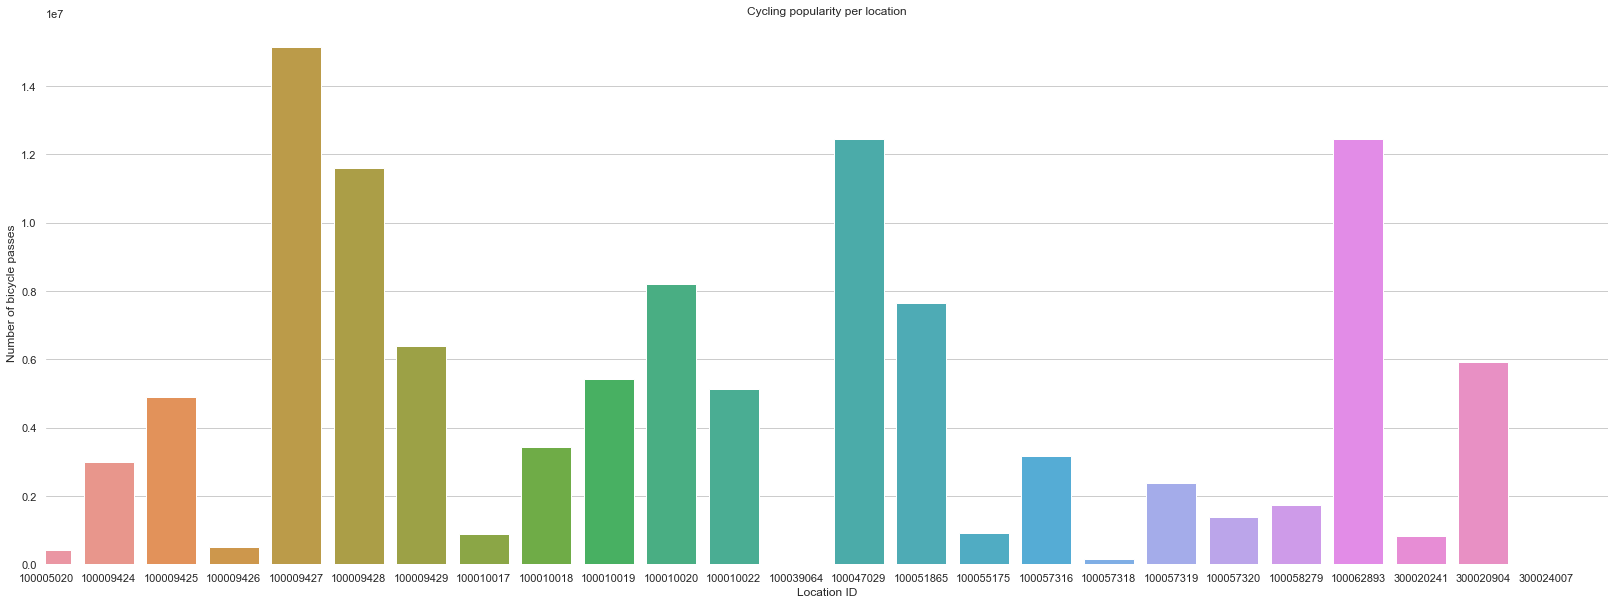

In [31]:
# Visualise to see which location has the highest count of cycling
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialize the matplotlib figure
f, g = plt.subplots(figsize=(28, 10))

g=sns.barplot(x = df["id"], y = df["counts"])

# Add a legend and informative axis label
g.set(xlim=(0, 25), ylabel="Number of bicycle passes",
       xlabel="Location ID")
g.set_title('Cycling popularity per location')
sns.despine(left=True, bottom=True)
plt.show()

# Number of Cycle passes varies considerably by location
# Potential to drill down for further analysis on these locations versus time of day, week etc.
# Discuss with team how to best represent this

## EDA on Parking DataFrame

### Data Wrangling

In [32]:
# Check for missing values in parking
parking.isnull().sum()

# Lots of missing values in several columns
# Looks like address/geographical data
# Makes sense there are missing values
# Not all columns required/available to complete an address

BoroCode          0
BoroName          0
CounDist          0
AssemDist         0
StSenDist         0
CongDist          0
STREETON      12468
XSTREET1       8297
XSTREET2       8407
SIDE          11783
ASSETSUBTY        0
dtype: int64

In [33]:
# View dataframe parking
parking.sample(10)

,BoroCode,BoroName,CounDist,AssemDist,StSenDist,CongDist,STREETON,XSTREET1,XSTREET2,SIDE,ASSETSUBTY
21087,4,Queens,19,26,11,3,150 ST,14 AV,12 RD,E,Small Hoop
14767,4,Queens,26,37,12,12,JACKSON AV,23 ST,46 AV,N,Small Hoop
24527,1,Manhattan,4,67,27,12,BROADWAY,W 54 ST,W 53 ST,NaN,Large Hoop
7993,1,Manhattan,10,72,31,13,BROADWAY,ISHAM ST,W 207 ST,W,Small Hoop
20316,3,Brooklyn,33,52,26,7,NaN,HENRY ST,HICKS ST,NaN,U-Rack
3770,4,Queens,21,34,13,14,37 AV,NaN,NaN,N,Small Hoop
6438,3,Brooklyn,38,51,17,7,8 AV,NaN,NaN,NaN,Large Hoop
4837,3,Brooklyn,36,57,25,8,NaN,PACIFIC ST,DEAN ST,W,U-Rack
21346,1,Manhattan,5,76,28,12,NaN,E 68 ST,E 69 ST,NaN,U-Rack
6253,1,Manhattan,2,74,28,12,NaN,E 29 ST,E 30 ST,E,U-Rack


In [34]:
# Count the number of unique values for each column
print(parking.nunique())

# How to marry this with counts data which has 25 unique location ids?

BoroCode         5
BoroName         5
CounDist        51
AssemDist       65
StSenDist       26
CongDist        13
STREETON      1671
XSTREET1      2608
XSTREET2      2724
SIDE             4
ASSETSUBTY      11
dtype: int64


## EDA on Routes DataFrame

### Data Wrangling

In [35]:
# Check for missing values
routes.isnull().sum()

# Missing value in just one column
# Looks like geographic location details again

segmentid        0
boro             0
street           0
fromstreet       0
tostreet         0
bikedir          0
lanecount        0
ft_facilit    5394
dtype: int64

In [36]:
# View dataframe
routes.sample(10)

,segmentid,boro,street,fromstreet,tostreet,bikedir,lanecount,ft_facilit
17411,320.182,4,ALLEY POND PARK GREENWAY,73 AV,76 AV,2,2,Greenway
9234,147.324,3,4 AV,17 ST,PROSPECT AV,L,1,NaN
350,15.87,5,VANDERBILT AV,PLEASANT PL,BAY ST,2,2,Standard
5949,76.582,4,ELMHURST AV,BROADWAY,91 ST,R,1,Standard
13858,239.765,1,HARLEM RIVER DR GREENWAY,E 133 ST,W 145 ST,2,2,Greenway
8723,134.467,2,UNIVERSITY HEIGHTS BR,BRONX BOROUGH BOUNDARY,CEDAR AV,2,0,NaN
13513,237.264,2,SHORE RD GREENWAY,PELHAM BR,PARK DR,2,2,Greenway
18861,"9,006,258",2,E 147 ST,ST ANNS AV,3 AV,L,1,NaN
13177,234.212,4,HIGHLAND PARK GREENWAY,HIGHLAND BLVD,J ROBINSON PKWY SR,2,2,Greenway
5830,75.577,4,59 ST,34 AV,39 AV,R,1,Sharrows


In [37]:
# Count the number of unique values for each column
print(routes.nunique())

# Boro in routes will merge with borocode in parking
# Still cant figure out how to marry these with counts dataframe.

segmentid     20792
boro              5
street         1292
fromstreet     1478
tostreet       1496
bikedir           3
lanecount         4
ft_facilit       14
dtype: int64


# Data Analysis